<a href="https://colab.research.google.com/github/zxcasd945/DRL/blob/main/DQN_25grids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import random
#either train a whole 5*5 grids with 1 and 0, for 1 is where the state is ,0 is the rest.
#or [ 0 1 0 0 .....]  for 1 is where the state is ,0 is the rest.
class Environment:
    def __init__(self):
        self.height = 5
        self.width = 5
        self.agent_pos = (0, 0)
        self.treasure_pos = (4, 4)
        self.actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]  # (left, right, up, down)
        self.state_space = self.width * self.height
        self.action_space = len(self.actions)

    def reset(self):
        self.agent_pos = (0, 0)
        self.done = False
        return 0, 0, False

    def step(self, action):
        x, y = self.agent_pos
        dx, dy = self.actions[action]
        new_x, new_y = x + dx, y + dy

        # Check if the agent hits a wall, if so, stay in the same place
        if 0 <= new_x < self.width and 0 <= new_y < self.height:
            self.agent_pos = (new_x, new_y)

        done = (self.agent_pos == self.treasure_pos)
        next_state = self.agent_pos[0] * self.height + self.agent_pos[1]

        reward = torch.tensor([1]) if done else torch.tensor([0]) # reward at (4,4)
        return next_state, reward, done

import torch
import torch.nn as nn
import torch.optim as optim

class QNetwork(nn.Module):
    def __init__(self, state_space, action_space):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_space, 64) #reduce hidden units.
        self.fc2 = nn.Linear(64, 20)
        self.fc3 = nn.Linear(20, action_space)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
class DQNAgent:
    def __init__(self, env, model, target_model, optimizer, loss_fn,batch_size=32, gamma=0.5, memory_capacity=10000, target_update_frequency=100):
        self.env = env
        self.q_net = model #predict
        self.target_net = target_model #ground truth
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.memory = []  # Experience replay buffer
        self.batch_size = batch_size
        self.gamma = gamma
        self.target_update_frequency = target_update_frequency
        self.target_update_counter = 1
        self.loss_list = []
        self.counter_list=[]
    def select_action(self, state):
        if np.random.uniform() < self.epsilon:
            return np.random.choice(self.env.action_space)  # Choose a random action
        else:
            with torch.no_grad():

                q_values = self.q_net(state)
                return torch.argmax(q_values).item()
    #Manage replay buffer.
    #imitation
    #transfer
    #階層式 hdrl hierachical deep reinforcement learning.
    #sac ppc dd
    # type of dqn

    def optimize_model(self):
        train_loss = 0
        loss_steps = 1


        self.target_update_counter += 1
        if self.target_update_counter % self.target_update_frequency == 0:

            self.target_net.load_state_dict(self.q_net.state_dict())  #q_net is estimated realtime model #target_net is used to train the data from real time model, so it's more accurate

            batch = random.sample(self.memory, self.batch_size)

            state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

            state_batch = torch.vstack(state_batch)
            next_state_batch = torch.vstack(next_state_batch)
            action_batch = torch.vstack(action_batch)
            reward_batch = torch.stack(reward_batch).type(torch.float32)

            current_q_values = self.q_net(state_batch).gather(1, action_batch)  #q_net is estimated model. select specific values from
            target_q_values=[]
            for individual_batch in batch:
              if individual_batch[4] == True:

                target_q_value = individual_batch[2].unsqueeze(0)
                target_q_values.append(target_q_value)
              else:
                next_q_value = self.target_net(individual_batch[0]).max(1)[0].view(-1, 1)
                target_q_value = individual_batch[2].unsqueeze(0) + self.gamma * next_q_value
                target_q_values.append(target_q_value)
            target_q_values = torch.vstack(target_q_values)
            #print(f'reward batch{reward_batch}')
            #print(f'new state{new_next_state_btach.shape}')
            #print(f'state batch shape:{new_state_batch.shape}')
            #print(f'This is q net {self.q_net(state_batch)}')


            #the Q-values produced by the neural network self.q_net based on the actions in the action_batch.

            #print(f'predicted q value:{current_q_values.shape}')



                #target_net is acting like ground truth,  self.target_net(next_state_batch).max(1)[0] is more accurate next state

              #print(f'ground truth q value:{next_q_values}')
              #print(f'rb:{reward_batch},next q:{next_q_values}')


            #print(f'target q :{target_q_values}')
            #print(f'This is current Q{current_q_values}')

            loss = self.loss_fn(target_q_values, current_q_values)
            train_loss+=abs(loss.item())*10000
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_steps += 1
            #train_loss.sum()/loss_steps
            self.loss_list.append(train_loss/loss_steps)
            self.counter_list.append(self.target_update_counter)
            #print(self.counter_list)
            #print(self.loss_list)



        #return loss_steps, loss_list, counter_list

env = Environment()
state_space = env.state_space
action_space = env.action_space
q_net = QNetwork(state_space, action_space)
target_net = QNetwork(state_space, action_space)
loss_fn = nn.MSELoss()
decay = 0.15
epsilon = 0.15
lr=0.002
optimizer = optim.Adam(q_net.parameters(), lr=lr)
agent = DQNAgent(env, q_net, target_net, optimizer, loss_fn)



import matplotlib.pyplot as plt
from tqdm.auto import tqdm
epochs = 1000
plot_steps=[]
plot_epochs=[]
plot_counter_list=[]
for i in tqdm(range(epochs)):
    state, _, done = env.reset()
    steps = 0

    while not done:

        state_tensor = torch.tensor([state], dtype=torch.float32)
        #print(state_tensor.dtype)
        state_input= torch.zeros(1, env.state_space)
        state_input[0][int(state_tensor)] = 1


        if np.random.uniform() < epsilon:
            action=np.random.choice(env.action_space)  # Choose a random action
        else:
            with torch.no_grad():

                q_values = q_net(state_input)
                action = torch.argmax(q_values).item()
        next_state, reward, done = env.step(action)

        #print(state_tensor, action,reward,torch.tensor([next_state], dtype=torch.float32), done)
        next_state = torch.tensor([next_state], dtype=torch.float32)
        next_state_input = torch.zeros(1, env.state_space)
        next_state_input[0][int(next_state)] = 1
        action = torch.tensor(action, dtype = torch.int64)
        agent.memory.append((state_input, action, reward, next_state_input, done))  #(St, at, Rt, St+1, Done)
        agent.optimize_model()
        #loss_steps, loss_list, counter_list = agent.optimize_model()

        state = next_state
        steps += 1
    agent.memory.append((state_input, action, reward, next_state_input, done))  #(St, at, Rt, St+1, Done)
    epsilon -= decay*epsilon
    print(f"Epoch {i + 1}/{epochs}, Done in {steps} steps")
    plot_steps.append(steps)
    plot_epochs.append(i)
print(len(agent.loss_list))
print(len(agent.counter_list))




plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(plot_epochs,plot_steps)
plt.title('Total steps')
plt.xlabel('Epochs')


plt.subplot(1,2,2)
plt.plot(agent.counter_list,agent.loss_list)
plt.title('Loss')
plt.xlabel('Epochs')


  0%|          | 0/1000 [00:00<?, ?it/s]

UnboundLocalError: ignored

In [ ]:
import torch
from torch import nn
import random
data=[]
a=(1,2,3,4,5)
b=(5,4,3,2,1)
c=(8,8,8,8,8)
data.append(a)
data.append(b)
data.append(c)
data
for x in data:
  print('yes') if x[2] == 3 else None

yes
yes


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 1/5000, Done in 23646 steps
Epoch 2/5000, Done in 1652 steps
Epoch 3/5000, Done in 564 steps
Epoch 4/5000, Done in 86 steps
Epoch 5/5000, Done in 515 steps
Epoch 6/5000, Done in 357 steps
Epoch 7/5000, Done in 4087 steps
Epoch 8/5000, Done in 755 steps
Epoch 9/5000, Done in 78 steps
Epoch 10/5000, Done in 217 steps
Epoch 11/5000, Done in 135 steps
Epoch 12/5000, Done in 29 steps
Epoch 13/5000, Done in 173 steps
Epoch 14/5000, Done in 523 steps
Epoch 15/5000, Done in 1314 steps
Epoch 16/5000, Done in 157 steps
Epoch 17/5000, Done in 173 steps
Epoch 18/5000, Done in 509 steps
Epoch 19/5000, Done in 47 steps
Epoch 20/5000, Done in 1618 steps
Epoch 21/5000, Done in 365 steps
Epoch 22/5000, Done in 563 steps
Epoch 23/5000, Done in 12 steps
Epoch 24/5000, Done in 172 steps
Epoch 25/5000, Done in 74 steps
Epoch 26/5000, Done in 29 steps
Epoch 27/5000, Done in 680 steps
Epoch 28/5000, Done in 8 steps
Epoch 29/5000, Done in 8 steps
Epoch 30/5000, Done in 8 steps
Epoch 31/5000, Done in 8 s

Text(0.5, 0, 'Time(Total steps)')

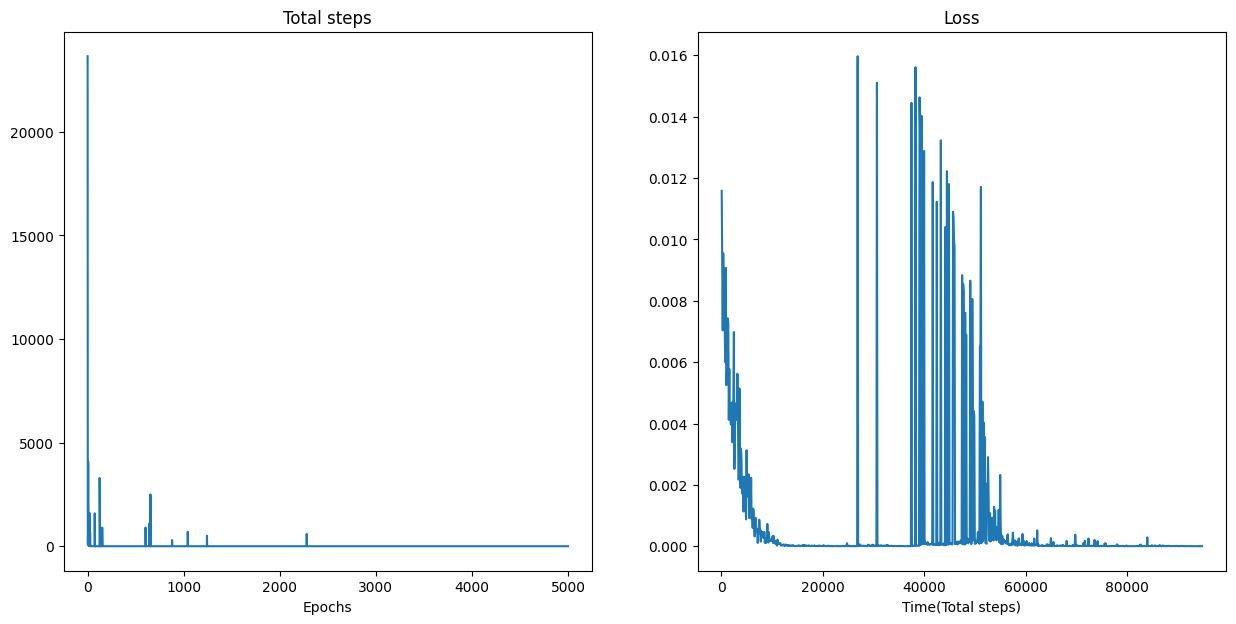

In [14]:
import numpy as np
import random
#either train a whole 5*5 grids with 1 and 0, for 1 is where the state is ,0 is the rest.
#or [ 0 1 0 0 .....]  for 1 is where the state is ,0 is the rest.
class Environment:
    def __init__(self):
        self.height = 5
        self.width = 5
        self.agent_pos = (0, 0)
        self.treasure_pos = (4, 4)
        self.actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]  # (left, right, up, down)
        self.state_space = self.width * self.height
        self.action_space = len(self.actions)

    def reset(self):
        self.agent_pos = (0, 0)
        self.done = False
        return 0, 0, False

    def step(self, action):
        x, y = self.agent_pos
        dx, dy = self.actions[action]
        new_x, new_y = x + dx, y + dy

        # Check if the agent hits a wall, if so, stay in the same place
        if 0 <= new_x < self.width and 0 <= new_y < self.height:
            self.agent_pos = (new_x, new_y)

        done = (self.agent_pos == self.treasure_pos)
        next_state = self.agent_pos[0] * self.height + self.agent_pos[1]

        reward = torch.tensor([1]) if done else torch.tensor([0]) # reward at (4,4)
        return next_state, reward, done

import torch
import torch.nn as nn
import torch.optim as optim

class QNetwork(nn.Module):
    def __init__(self, state_space, action_space):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_space, 64) #reduce hidden units.
        self.fc2 = nn.Linear(64, 20)
        self.fc3 = nn.Linear(20, action_space)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
class DQNAgent:
    def __init__(self, env, model, target_model, optimizer, loss_fn,batch_size=32, gamma=0.5, memory_capacity=10000, target_update_frequency=100):
        self.env = env
        self.q_net = model #predict
        self.target_net = target_model #ground truth
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.memory = []  # Experience replay buffer
        self.batch_size = batch_size
        self.gamma = gamma

        self.target_update_frequency = target_update_frequency
        self.target_update_counter = 1
        self.loss_list = []
        self.counter_list=[]
    def select_action(self, state):
        if np.random.uniform() < self.epsilon:
            return np.random.choice(self.env.action_space)  # Choose a random action
        else:
            with torch.no_grad():

                q_values = self.q_net(state)
                return torch.argmax(q_values).item()
    #Manage replay buffer.
    #imitation
    #transfer
    #階層式 hdrl hierachical deep reinforcement learning.
    #sac ppc dd
    # type of dqn

    def optimize_model(self):
        train_loss = 0

        loss_steps = 1

        self.target_update_counter += 1
        if self.target_update_counter % self.target_update_frequency == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())  #q_net is estimated realtime model #target_net is used to train the data from real time model, so it's more accurate

            batch = random.sample(self.memory, self.batch_size)
            state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
            state_batch = torch.vstack(state_batch)
            next_state_batch = torch.vstack(next_state_batch)
            action_batch = torch.vstack(action_batch)
            reward_batch = torch.stack(reward_batch)
            #print(f'reward batch{reward_batch}')
            #print(f'new state{new_next_state_btach.shape}')
            #print(f'state batch shape:{new_state_batch.shape}')
            #print(f'This is q net {self.q_net(state_batch)}')

            current_q_values = self.q_net(state_batch).gather(1, action_batch)  #q_net is estimated model. select specific values from
            #the Q-values produced by the neural network self.q_net based on the actions in the action_batch.
            #print(f'This is current Q with action batch{current_q_values}')
            #print(f'predicted q value:{self.target_net(next_state_batch)}')
            next_q_values = self.target_net(next_state_batch).max(1)[0].view(-1, 1)  #target_net is acting like ground truth,  self.target_net(next_state_batch).max(1)[0] is more accurate next state

            #print(f'ground truth q value:{next_q_values}')
            #print(f'rb:{reward_batch},next q:{next_q_values}')
            target_q_values = reward_batch + self.gamma * next_q_values


            #print(f'target q :{target_q_values}')
            loss = self.loss_fn(target_q_values, current_q_values)
            train_loss+=abs(loss.item())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_steps += 1
            self.loss_list.append(train_loss/loss_steps)
            self.counter_list.append(self.target_update_counter)





env = Environment()
state_space = env.state_space
action_space = env.action_space
q_net = QNetwork(state_space, action_space)
target_net = QNetwork(state_space, action_space)
loss_fn = nn.MSELoss()
decay = 0.1
epsilon = 0.2
lr=0.001
optimizer = optim.Adam(q_net.parameters(), lr=lr)
agent = DQNAgent(env, q_net, target_net, optimizer, loss_fn)



import matplotlib.pyplot as plt
from tqdm.auto import tqdm
epochs = 5000
plot_steps=[]
plot_epochs=[]
loss_list = []
for i in tqdm(range(epochs)):
    state, _, done = env.reset()
    steps = 0

    while not done:

        state_tensor = torch.tensor([state], dtype=torch.float32)
        #print(state_tensor.dtype)
        state_input= torch.zeros(1, env.state_space)
        state_input[0][int(state_tensor)] = 1


        if np.random.uniform() < epsilon:
            action=np.random.choice(env.action_space)  # Choose a random action
        else:
            with torch.no_grad():

                q_values = q_net(state_input)
                action = torch.argmax(q_values).item()
        next_state, reward, done = env.step(action)

        #print(state_tensor, action,reward,torch.tensor([next_state], dtype=torch.float32), done)
        next_state = torch.tensor([next_state], dtype=torch.float32)
        next_state_input = torch.zeros(1, env.state_space)
        next_state_input[0][int(next_state)] = 1
        action = torch.tensor(action, dtype = torch.int64)
        agent.memory.append((state_input, action, reward, next_state_input, done))  #(St, at, Rt, St+1, Done)
        agent.optimize_model()

        state = next_state
        steps += 1
    agent.memory.append((state_input, action, reward, next_state_input, done))  #(St, at, Rt, St+1, Done)
    epsilon -= decay*epsilon
    print(f"Epoch {i + 1}/{epochs}, Done in {steps} steps")
    plot_steps.append(steps)
    plot_epochs.append(i)


#print(loss_list)
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(plot_epochs,plot_steps)
plt.title('Total steps')
plt.xlabel('Epochs')


plt.subplot(1,2,2)
plt.plot(agent.counter_list,agent.loss_list)
plt.title('Loss')
plt.xlabel('Time(Total steps)')

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500, Done in 57 steps
Epoch 2/500, Done in 266 steps
Epoch 3/500, Done in 371 steps
Epoch 4/500, Done in 419 steps
Epoch 5/500, Done in 454 steps
Epoch 6/500, Done in 84 steps
Epoch 7/500, Done in 595 steps
Epoch 8/500, Done in 2110 steps
Epoch 9/500, Done in 101 steps
Epoch 10/500, Done in 134 steps
Epoch 11/500, Done in 17 steps
Epoch 12/500, Done in 145 steps
Epoch 13/500, Done in 38 steps
Epoch 14/500, Done in 366 steps
Epoch 15/500, Done in 131 steps
Epoch 16/500, Done in 46 steps
Epoch 17/500, Done in 28 steps
Epoch 18/500, Done in 16 steps
Epoch 19/500, Done in 40 steps
Epoch 20/500, Done in 34 steps
Epoch 21/500, Done in 102 steps
Epoch 22/500, Done in 216 steps
Epoch 23/500, Done in 10 steps
Epoch 24/500, Done in 74 steps
Epoch 25/500, Done in 241 steps
Epoch 26/500, Done in 111 steps
Epoch 27/500, Done in 8 steps
Epoch 28/500, Done in 8 steps
Epoch 29/500, Done in 8 steps
Epoch 30/500, Done in 8 steps
Epoch 31/500, Done in 8 steps
Epoch 32/500, Done in 8 steps
Epoch 3

Text(0.5, 0, 'Epochs')

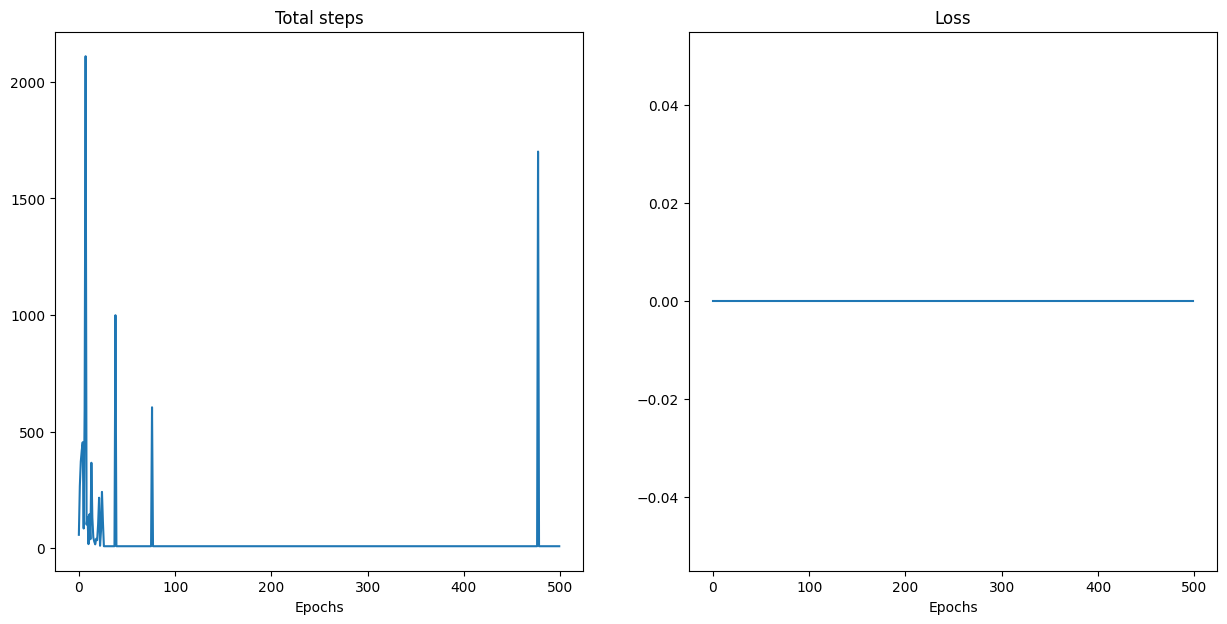

In [ ]:
###Version 1#########
import numpy as np
import random
#either train a whole 5*5 grids with 1 and 0, for 1 is where the state is ,0 is the rest.
#or [ 0 1 0 0 .....]  for 1 is where the state is ,0 is the rest.
class Environment:
    def __init__(self):
        self.height = 5
        self.width = 5
        self.agent_pos = (0, 0)
        self.treasure_pos = (4, 4)
        self.actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]  # (left, right, up, down)
        self.state_space = self.width * self.height
        self.action_space = len(self.actions)

    def reset(self):
        self.agent_pos = (0, 0)
        self.done = False
        return 0, 0, False

    def step(self, action):
        x, y = self.agent_pos
        dx, dy = self.actions[action]
        new_x, new_y = x + dx, y + dy

        # Check if the agent hits a wall, if so, stay in the same place
        if 0 <= new_x < self.width and 0 <= new_y < self.height:
            self.agent_pos = (new_x, new_y)

        done = (self.agent_pos == self.treasure_pos)
        next_state = self.agent_pos[0] * self.height + self.agent_pos[1]

        reward = torch.tensor([1]) if done else torch.tensor([0]) # reward at (4,4)
        return next_state, reward, done

import torch
import torch.nn as nn
import torch.optim as optim

class QNetwork(nn.Module):
    def __init__(self, state_space, action_space):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_space, 64) #reduce hidden units.
        self.fc2 = nn.Linear(64, 20)
        self.fc3 = nn.Linear(20, action_space)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
class DQNAgent:
    def __init__(self, env, model, target_model, optimizer, loss_fn,batch_size=32, gamma=0.5, memory_capacity=10000, target_update_frequency=100):
        self.env = env
        self.q_net = model #predict
        self.target_net = target_model #ground truth
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.memory = []  # Experience replay buffer
        self.batch_size = batch_size
        self.gamma = gamma

        self.target_update_frequency = target_update_frequency
        self.target_update_counter = 1

    def select_action(self, state):
        if np.random.uniform() < self.epsilon:
            return np.random.choice(self.env.action_space)  # Choose a random action
        else:
            with torch.no_grad():

                q_values = self.q_net(state)
                return torch.argmax(q_values).item()
    #Manage replay buffer.
    #imitation
    #transfer
    #階層式 hdrl hierachical deep reinforcement learning.
    #sac ppc dd
    # type of dqn

    def optimize_model(self):
        train_loss = 0

        loss_steps = 1

        self.target_update_counter += 1
        if self.target_update_counter % self.target_update_frequency == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())  #q_net is estimated realtime model #target_net is used to train the data from real time model, so it's more accurate

            batch = random.sample(self.memory, self.batch_size)
            state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
            state_batch = torch.vstack(state_batch)
            next_state_batch = torch.vstack(next_state_batch)
            action_batch = torch.vstack(action_batch)
            reward_batch = torch.stack(reward_batch)
            #print(f'reward batch{reward_batch}')
            #print(f'new state{new_next_state_btach.shape}')
            #print(f'state batch shape:{new_state_batch.shape}')
            #print(f'This is q net {self.q_net(state_batch)}')

            current_q_values = self.q_net(state_batch).gather(1, action_batch)  #q_net is estimated model. select specific values from
            #the Q-values produced by the neural network self.q_net based on the actions in the action_batch.
            #print(f'This is current Q with action batch{current_q_values}')
            #print(f'predicted q value:{current_q_values.shape}')
            next_q_values = self.target_net(next_state_batch).max(1)[0].view(-1, 1)  #target_net is acting like ground truth,  self.target_net(next_state_batch).max(1)[0] is more accurate next state

            #print(f'ground truth q value:{next_q_values}')
            #print(f'rb:{reward_batch},next q:{next_q_values}')
            target_q_values = reward_batch + self.gamma * next_q_values


            #print(f'target q :{target_q_values}')
            loss = self.loss_fn(target_q_values, current_q_values)
            train_loss+=abs(loss.item())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_steps += 1
        train_loss = train_loss/loss_steps

        return loss_steps, train_loss


env = Environment()
state_space = env.state_space
action_space = env.action_space
q_net = QNetwork(state_space, action_space)
target_net = QNetwork(state_space, action_space)
loss_fn = nn.MSELoss()
decay = 0.1
epsilon = 0.2
lr=0.001
optimizer = optim.Adam(q_net.parameters(), lr=lr)
agent = DQNAgent(env, q_net, target_net, optimizer, loss_fn)



import matplotlib.pyplot as plt
from tqdm.auto import tqdm
epochs = 500
plot_steps=[]
plot_epochs=[]
loss_list = []
for i in tqdm(range(epochs)):
    state, _, done = env.reset()
    steps = 0

    while not done:

        state_tensor = torch.tensor([state], dtype=torch.float32)
        #print(state_tensor.dtype)
        state_input= torch.zeros(1, env.state_space)
        state_input[0][int(state_tensor)] = 1


        if np.random.uniform() < epsilon:
            action=np.random.choice(env.action_space)  # Choose a random action
        else:
            with torch.no_grad():

                q_values = q_net(state_input)
                action = torch.argmax(q_values).item()
        next_state, reward, done = env.step(action)

        #print(state_tensor, action,reward,torch.tensor([next_state], dtype=torch.float32), done)
        next_state = torch.tensor([next_state], dtype=torch.float32)
        next_state_input = torch.zeros(1, env.state_space)
        next_state_input[0][int(next_state)] = 1
        action = torch.tensor(action, dtype = torch.int64)
        agent.memory.append((state_input, action, reward, next_state_input, done))  #(St, at, Rt, St+1, Done)
        loss_steps, train_loss = agent.optimize_model()

        state = next_state
        steps += 1
    agent.memory.append((state_input, action, reward, next_state_input, done))  #(St, at, Rt, St+1, Done)
    epsilon -= decay*epsilon
    print(f"Epoch {i + 1}/{epochs}, Done in {steps} steps")
    plot_steps.append(steps)
    plot_epochs.append(i)
    loss_list.append(train_loss)

#print(loss_list)
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(plot_epochs,plot_steps)
plt.title('Total steps')
plt.xlabel('Epochs')


plt.subplot(1,2,2)
plt.plot(plot_epochs,loss_list)
plt.title('Loss')
plt.xlabel('Epochs')

In [ ]:
import numpy as np
import random
#either train a whole 5*5 grids with 1 and 0, for 1 is where the state is ,0 is the rest.
#or [ 0 1 0 0 .....]  for 1 is where the state is ,0 is the rest.
class Environment:
    def __init__(self):
        self.height = 5
        self.width = 5
        self.agent_pos = (0, 0)
        self.treasure_pos = (4, 4)
        self.actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]  # (left, right, up, down)
        self.state_space = self.width * self.height
        self.action_space = len(self.actions)

    def reset(self):
        self.agent_pos = (0, 0)
        self.done = False
        return 0, 0, False

    def step(self, action):
        x, y = self.agent_pos
        dx, dy = self.actions[action]
        new_x, new_y = x + dx, y + dy

        # Check if the agent hits a wall, if so, stay in the same place
        if 0 <= new_x < self.width and 0 <= new_y < self.height:
            self.agent_pos = (new_x, new_y)

        done = (self.agent_pos == self.treasure_pos)
        next_state = self.agent_pos[0] * self.height + self.agent_pos[1]

        reward = torch.tensor([1]) if done else torch.tensor([0]) # reward at (4,4)
        return next_state, reward, done

import torch
import torch.nn as nn
import torch.optim as optim

class QNetwork(nn.Module):
    def __init__(self, state_space, action_space):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_space, 64) #reduce hidden units.
        self.fc2 = nn.Linear(64, 20)
        self.fc3 = nn.Linear(20, action_space)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
class DQNAgent:
    def __init__(self, env, model, target_model, optimizer, loss_fn,batch_size=32, gamma=0.5, memory_capacity=10000, target_update_frequency=100):
        self.env = env
        self.q_net = model #predict
        self.target_net = target_model #ground truth
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.memory = []  # Experience replay buffer
        self.batch_size = batch_size
        self.gamma = gamma
        self.target_update_frequency = target_update_frequency
        self.target_update_counter = 1
        self.loss_list = []
        self.counter_list=[]
    def select_action(self, state):
        if np.random.uniform() < self.epsilon:
            return np.random.choice(self.env.action_space)  # Choose a random action
        else:
            with torch.no_grad():

                q_values = self.q_net(state)
                return torch.argmax(q_values).item()
    #Manage replay buffer.
    #imitation
    #transfer
    #階層式 hdrl hierachical deep reinforcement learning.
    #sac ppc dd
    # type of dqn

    def optimize_model(self):
        train_loss = 0
        loss_steps = 1


        self.target_update_counter += 1
        if self.target_update_counter % self.target_update_frequency == 0:

            self.target_net.load_state_dict(self.q_net.state_dict())  #q_net is estimated realtime model #target_net is used to train the data from real time model, so it's more accurate

            batch = random.sample(self.memory, self.batch_size)

            state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

            state_batch = torch.vstack(state_batch)
            next_state_batch = torch.vstack(next_state_batch)
            action_batch = torch.vstack(action_batch)
            reward_batch = torch.stack(reward_batch).type(torch.float32)

            current_q_values = self.q_net(state_batch).gather(1, action_batch)  #q_net is estimated model. select specific values from

            for individual_batch in batch:
              if individual_batch[4] == True:

                target_q_values = reward_batch
              else:
                next_q_values = self.target_net(next_state_batch).max(1)[0].view(-1, 1)
                target_q_values = reward + self.gamma * next_q_values
            #print(f'reward batch{reward_batch}')
            #print(f'new state{new_next_state_btach.shape}')
            #print(f'state batch shape:{new_state_batch.shape}')
            #print(f'This is q net {self.q_net(state_batch)}')


            #the Q-values produced by the neural network self.q_net based on the actions in the action_batch.

            #print(f'predicted q value:{current_q_values.shape}')



                #target_net is acting like ground truth,  self.target_net(next_state_batch).max(1)[0] is more accurate next state

              #print(f'ground truth q value:{next_q_values}')
              #print(f'rb:{reward_batch},next q:{next_q_values}')


            #print(f'target q :{target_q_values}')
            #print(f'This is current Q{current_q_values}')

            loss = self.loss_fn(target_q_values, current_q_values)
            train_loss+=abs(target_q_values-current_q_values)*10000
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_steps += 1
            #train_loss.sum()/loss_steps
            self.loss_list.append((train_loss.sum()/loss_steps).item())
            self.counter_list.append(self.target_update_counter)
            #print(self.counter_list)
            #print(self.loss_list)

            loss = self.loss_fn(target_q_values, current_q_values)
            train_loss+=abs(loss.item())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_steps += 1
            self.loss_list.append(train_loss/loss_steps)
            self.counter_list.append(self.target_update_counter)

        #return loss_steps, loss_list, counter_list

env = Environment()
state_space = env.state_space
action_space = env.action_space
q_net = QNetwork(state_space, action_space)
target_net = QNetwork(state_space, action_space)
loss_fn = nn.MSELoss()
decay = 0.1
epsilon = 0.2
lr=0.001
optimizer = optim.Adam(q_net.parameters(), lr=lr)
agent = DQNAgent(env, q_net, target_net, optimizer, loss_fn)



import matplotlib.pyplot as plt
from tqdm.auto import tqdm
epochs = 5000
plot_steps=[]
plot_epochs=[]
plot_counter_list=[]
for i in tqdm(range(epochs)):
    state, _, done = env.reset()
    steps = 0

    while not done:

        state_tensor = torch.tensor([state], dtype=torch.float32)
        #print(state_tensor.dtype)
        state_input= torch.zeros(1, env.state_space)
        state_input[0][int(state_tensor)] = 1


        if np.random.uniform() < epsilon:
            action=np.random.choice(env.action_space)  # Choose a random action
        else:
            with torch.no_grad():

                q_values = q_net(state_input)
                action = torch.argmax(q_values).item()
        next_state, reward, done = env.step(action)

        #print(state_tensor, action,reward,torch.tensor([next_state], dtype=torch.float32), done)
        next_state = torch.tensor([next_state], dtype=torch.float32)
        next_state_input = torch.zeros(1, env.state_space)
        next_state_input[0][int(next_state)] = 1
        action = torch.tensor(action, dtype = torch.int64)
        agent.memory.append((state_input, action, reward, next_state_input, done))  #(St, at, Rt, St+1, Done)
        agent.optimize_model()
        #loss_steps, loss_list, counter_list = agent.optimize_model()

        state = next_state
        steps += 1
    agent.memory.append((state_input, action, reward, next_state_input, done))  #(St, at, Rt, St+1, Done)
    epsilon -= decay*epsilon
    print(f"Epoch {i + 1}/{epochs}, Done in {steps} steps")
    plot_steps.append(steps)
    plot_epochs.append(i)
print(agent.loss_list)
print(agent.counter_list)




plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(plot_epochs,plot_steps)
plt.title('Total steps')
plt.xlabel('Epochs')


plt.subplot(1,2,2)
plt.plot(agent.counter_list,agent.loss_list)
plt.title('Loss')
plt.xlabel('Epochs')


In [8]:
a=torch.tensor([[ 0.0750,  0.1430,  0.1621,  0.0834]])
a.max(1)[0]

tensor([0.1621])